# Notebook 02: EDA

## Contents:

## Summary:
This notebook contains cleaning and exploration of the dataset with the goal of identifying any underlying trends and preparing the data for modeling. Text will be normalized and song structure will be reviewed.

Importing necessary libraries.

In [246]:
import json, time, re, requests, pickle
import pandas as pd
import psycopg2 as pg2
import numpy as np
import matplotlib.pyplot as plt
import plotly as py
import plotly.graph_objs as go

from psycopg2.extras import RealDictCursor, Json
from psycopg2.extensions import AsIs

%matplotlib inline
plt.style.use('fivethirtyeight')

%run ../assets/sql_cred.py
%run ../assets/plotly_cred.py

Submitting credentials for access to the Plotly API.

In [208]:
py.tools.set_credentials_file(username=USERNAME, api_key=API_KEY)

Defining a helper function for saving out files with timestamping and file logging.

In [2]:
def filename_format_log(file_path, 
                        logfile = '../assets/file_log.txt', 
                        now = round(time.time()), 
                        file_description = None): 
   
    try:
        ext = re.search('(?<!^)(?<!\.)\.(?!\.)', file_path).start() 
    except:
        raise NameError('Please enter a relative path with a file extension.') 
    
    stamp = re.search('(?<!^)(?<!\.)[A-z]+_[0-z]+(?=\.)', file_path).start()
    formatted_name = f'{file_path[:stamp]}{now}_{file_path[stamp:]}'  
    if not file_description:
        file_description = f'Saved at: {time.asctime(time.gmtime(now))}'
    with open(logfile, 'a+') as f:
        f.write(f'{formatted_name}: {file_description}\n')
    return formatted_name, now, file_description

Reusing the SQL helper functions for database querying the track_list db

In [4]:
def con_cur_to_db(dbname=DBNAME, dict_cur=None):
    con = pg2.connect(host=IP_ADDRESS,
                  dbname=dbname,
                  user=USER,
                  password=PASSWORD)
    if dict_cur:
        cur = con.cursor(cursor_factory=RealDictCursor)
    else:
        cur = con.cursor()
    return con, cur
    
def execute_query(query, dbname=DBNAME, dict_cur=None, command=False):
    con, cur = con_cur_to_db(dbname, dict_cur)
    cur.execute(f'{query}')
    if not command:
        data = cur.fetchall()
        con.close()
        return data
    con.commit() #sends to server
    con.close() #closes server connection

In [119]:
query = '''SELECT * FROM track_list;'''
response = execute_query(query, dict_cur=True)
track_df = pd.DataFrame(response)
track_df.set_index('track_id', inplace=True)
track_df.head()

,album_name,artist_name,lyrics,playlist_id,playlist_name,playlist_owner,track_name
track_id,,,,,,,
0h7TlF8gKb61aSm874s3cV,I Can't Tell You How Much It Hurts,moow,\n\nIf your needle is near\nNeedle is near\nYo...,37i9dQZF1DXarebqD2nAVg,Tender,spotify,You'r in My Head
6koowTu9pFHPEcZnACLKbK,Coming Home,Leon Bridges,\n\n[Verse 1]\nBrown skin girl on the other si...,37i9dQZF1DX4adj7PFEBwf,Wedding Bells,spotify,Brown Skin Girl
1JkhKUXAoNivi87ipmV3rp,Back To Love (Deluxe Version),Anthony Hamilton,"\n\n[Verse 1]\nIt's simple, I love it\nHaving ...",37i9dQZF1DX4adj7PFEBwf,Wedding Bells,spotify,Best of Me
51lPx6ZCSalL2kvSrDUyJc,The Search for Everything,John Mayer,\n\n[Intro: Whistling]\n\n[Verse 1]\nA great b...,37i9dQZF1DX4adj7PFEBwf,Wedding Bells,spotify,You're Gonna Live Forever in Me
3vqlZUIT3rEmLaYKDBfb4Q,Songs In The Key Of Life,Stevie Wonder,\n\n[Verse 1]\nIsn't she lovely\nIsn't she won...,37i9dQZF1DX4adj7PFEBwf,Wedding Bells,spotify,Isn't She Lovely


Saving out the lyrics column in a separate dataframe for cleaning and analysis

In [120]:
lyric_df = track_df[['lyrics']]

Checking shape before cleaning.

In [122]:
lyric_df.shape

(2276, 1)

## Dropping or Ammending Lyrics

Dropping or appending tracks that have been identified below as having errors such as non-song text, non-english text, missing tags, long whitespace gaps, etc prior to cleaning.

Dropping any null values.

In [121]:
lyric_df = lyric_df.dropna(axis=0)

Not english

In [123]:
lyric_df = lyric_df.drop(index='1mjWhM7GQTTxJxg2F0iCRS', axis=0)

In [124]:
lyric_df = lyric_df.drop(index='4tjLYTXFqZhkUDga4bQ0yl', axis=0)

In [140]:
lyric_df = lyric_df.drop(index='2za6PlkAQAMMu0VFsfBoHC', axis=0)

In [186]:
lyric_df =l yric_df.drop(index='0CNKS52qyUU9124pyENtbl', axis=0)

Missing ']' creating a tagging error.

In [125]:
lyric_df.loc['1Ob94QesoxHSBrypyBbdfd', 'lyrics'] = "\n\n[Verse 1]\nWe've been here before, surrounded in the cold\nYou take me to places I've never known\nAnd you push me to places I'll never go\nI would die for you\nTell me the truth\nAm I all that you would need?\nIf we're keeping it a hundred, you're all that I need for me\nFrom the jump until forever from now, I would ride for you\n\n[Chorus]\nBut you got me shot down by love\nYou got my heart now\nWhy won't you stop now?\nOh I've been knocked down by you\nYou got my heart now\nWhy won't you stop now?\n\n[Verse 2]\nI've been through it whole\nI've been through the worst\nBut I never knew how much our love could hurt\nOver my family I put you first\nWriting out my feelings is the only thing that work\nI don't hear from the friends I thought were mine too\nBut I hold on to the poems I would write you\nHappy seventeen, I saw us two and you saw three\nI guess our lines are structured like a haiku\n\n[Chorus 2]\nYou got me shot down by love\nAnd you got my heart now\nWhy won't you stop now?\nOh I've been knocked down by you\nAnd you got my heart now\nWhy won't you stop now?\n\n[Bridge]\nKnocked down, knocked down\nKnocked down, knocked down\nKnocked down\nKnocked down\n\n[Chorus]\nI've been shot down by love\nYou got my heart now\nWhy won't you stop now?\nI've been knocked down by you\nAnd you got my heart now\nWhy won't you stop now?\n\n"

Tracks identified by having too few total lines per track.

In [127]:
lyric_df.loc['2Wu9PNpLUCBl3W1GaPqkhl'].lyrics

'\n\nMorni Banke (Badhaai Ho) Guru Randhawa Neha Kakkar 320kbps Mp3 Songs Download, Morni Banke (Badhaai Ho) Guru Randhawa Neha Kakkar 320kbps iTunes Rip Mp3 Songs Download, Morni Banke (Badhaai Ho) Guru Randhawa Neha Kakkar 320kbps 128 Kbps Mp3 Songs Free Download, Morni Banke (Badhaai Ho) Guru Randhawa Neha Kakkar 320kbps 320 Kbps Mp3 Songs Free Download, Morni Banke (Badhaai Ho) Guru Randhawa Neha Kakkar 320kbps Mp3 Songs Download In High Quality, Morni Banke (Badhaai Ho) Guru Randhawa Neha Kakkar 320kbps Mp3 Songs Download 320kbps Quality, Morni Banke (Badhaai Ho) Guru Randhawa Neha Kakkar 320kbps Mp3 Songs Download, Morni Banke (Badhaai Ho) Guru Randhawa Neha Kakkar 320kbps All Mp3 Songs Download, Morni Banke (Badhaai Ho) Guru Randhawa Neha Kakkar 320kbps Full Songs Download\n\n'

In [128]:
lyric_df = lyric_df.drop(index='2Wu9PNpLUCBl3W1GaPqkhl', axis=0)

Mislabed lyrics with '\n\n' for linebreaks

In [129]:
lyric_df.loc['6xYd4zCVeSp80Un2Rl9wDs'].lyrics

"\n\nBaby let's cruise away from here\n\nDon't be confused baby, the way is clear\n\nAnd if you want it you got it forever\n\nOh, this is not a one night stand baby\n\nLet the music take your mind\n\nAnd just release and you will find, baby\n\nWe're going to fly away\n\nGlad you're going my way\n\nI love it when we're cruisin' together\n\nMusic was made for love\n\nCruisin' is made for love\n\nI love it when we're cruisin' together\n\nBaby, tonight belongs to us\n\nEverything's right, do what you must, baby\n\nAnd inch by inch we get closer and closer\n\nEvery little part of each other ooh, baby, baby\n\nLet the music take your mind\n\nJust release and you will find, baby\n\nWe're going to fly away\n\nGlad you're going my way\n\nI love it when we're cruisin' together\n\nMusic was made for love\n\nCruisin' is made for love\n\nI love you when we're cruisin' together\n\nWe're going to fly away\n\nGlad you're going my way\n\nI love it when we're cruisin' together\n\nMusic was made for love

In [130]:
lyric_df.loc['6xYd4zCVeSp80Un2Rl9wDs', 'lyrics'] = lyric_df.loc['6xYd4zCVeSp80Un2Rl9wDs'].lyrics.replace('\n\n','\n')

In [131]:
lyric_df.loc['6XkChVvxj0Cakfae17NaK3'].lyrics

'\n\nI ran into a woman on the sidewalk\n\n‘cause I was thinking too much about us\n\nDreaming of you and all we’ve lost\n\n‘Cause now you’re always so angry\n\nYou’re always so sad\n\nYou’re mad about everything and everyone and I\n\nI don’t have the heart for that\n\nHow we used to love\n\nI’m afraid for our future\n\nI’m afraid it won’t last\n\n‘Cause you’ve got too many scars to hide\n\nAnd I haven’t got enough to understand why\n\nWhy are you always so sad\n\nWhy are you always so\n\nWhy are you always so sad?\n\nHow we used to love\n\nHow we used to love\n\nHow we used to love\n\nHow we used to love\n\n'

In [132]:
lyric_df.loc['6XkChVvxj0Cakfae17NaK3', 'lyrics']= lyric_df.loc['6XkChVvxj0Cakfae17NaK3'].lyrics.replace('\n\n','\n')

In [133]:
lyric_df.loc['5ONPeQRp1m4KJ0M57qBj1D'].lyrics

"\n\nShe was too good to me\nShe was too good to me\n\nHow can I get along now\n\nSo close she stood to me\n\nEverything seems so wrong now\n\nShe would have brought me the sun\n\nMaking me smile\n\nThat was her fun\n\nWhen I was mean to her\n\nShe never said go away now\n\nI was a king to her\n\nWho's gonna make me gay now?\n\nIt's only natural\n\nI'm so blue\n\nShe was too good to be true\n\n"

In [134]:
lyric_df.loc['5ONPeQRp1m4KJ0M57qBj1D', 'lyrics'] = lyric_df.loc['5ONPeQRp1m4KJ0M57qBj1D'].lyrics.replace('\n\n','\n')

Not a song

In [135]:
lyric_df.loc['44z4AP1yhEjcbihu5qdXsZ'].lyrics

'\n\nTo Noel Willmett\n\n18 May 1944\n10a Mortimer Crescent NW 6\n\nDear Mr Willmett,\n\nMany thanks for your letter. You ask whether totalitarianism, leader-worship etc. are really on the up-grade and instance the fact that they are not apparently growing in this country and the USA.\n\nI must say I believe, or fear, that taking the world as a whole these things are on the increase. Hitler, no doubt, will soon disappear, but only at the expense of strengthening (a) Stalin, (b) the Anglo-American millionaires and (c) all sorts of petty fuhrers° of the type of de Gaulle. All the national movements everywhere, even those that originate in resistance to German domination, seem to take non-democratic forms, to group themselves round some superhuman fuhrer (Hitler, Stalin, Salazar, Franco, Gandhi, De Valera are all varying examples) and to adopt the theory that the end justifies the means. Everywhere the world movement seems to be in the direction of centralised economies which can be made 

In [136]:
lyric_df = lyric_df.drop(index='44z4AP1yhEjcbihu5qdXsZ', axis=0)

In [137]:
lyric_df.loc['0cqSEpg2nYbneh7RGNrDcp'].lyrics

'\n\nToday I entered a bill to end the states involvement in the sanctioning of marriage. Right now, as it sits with the decision from our U.S. Supreme Court looming, our elected officials could be forced to perform same sex marriages; if this happens then the liberal left will use this Supreme Court decision as a hammer to advance their liberal agenda. If the Supreme Court surprises everyone and decides to uphold the institution of marriage then I will simply will have the option to then withdraw the bill. The winds of secular progressivism gives me the sense that our Supreme Court is handing us their next step in the end of traditional morality for America. This bill simply put will end our elected official’s involvement in performing marriage ceremonies.\n\nIt is incredibly important that if the Supreme Court rules against traditional marriage that our elected officials are not forced to violate their conscience and be forced to perform gay marriages. Further note on another piece o

In [138]:
lyric_df = lyric_df.drop(index='0cqSEpg2nYbneh7RGNrDcp', axis=0)

In [139]:
lyric_df.loc['2za6PlkAQAMMu0VFsfBoHC'].lyrics

'\n\nCHAPTER 1: A RUNAWAY REEF\n\nThe year 1866 was marked by a bizarre development, an unexplained and downright inexplicable phenomenon that surely no one has forgotten. Without getting into those rumors that upset civilians in the seaports and deranged the public mind even far inland, it must be said that professional seamen were especially alarmed. Traders, shipowners, captains of vessels, skippers, and master mariners from Europe and America, naval officers from every country, and at their heels the various national governments on these two continents, were all extremely disturbed by the business.\n\nIn essence, over a period of time several ships had encountered "an enormous thing" at sea, a long spindle–shaped object, sometimes giving off a phosphorescent glow, infinitely bigger and faster than any whale.\n\nThe relevant data on this apparition, as recorded in various logbooks, agreed pretty closely as to the structure of the object or creature in question, its unprecedented spe

In [141]:
lyric_df.head()

,lyrics
track_id,
0h7TlF8gKb61aSm874s3cV,\n\nIf your needle is near\nNeedle is near\nYo...
6koowTu9pFHPEcZnACLKbK,\n\n[Verse 1]\nBrown skin girl on the other si...
1JkhKUXAoNivi87ipmV3rp,"\n\n[Verse 1]\nIt's simple, I love it\nHaving ..."
51lPx6ZCSalL2kvSrDUyJc,\n\n[Intro: Whistling]\n\n[Verse 1]\nA great b...
3vqlZUIT3rEmLaYKDBfb4Q,\n\n[Verse 1]\nIsn't she lovely\nIsn't she won...


## Cleaning lyrics

Defining a helper function to clean and split the lyrics to prepare for modeling. '\n' characters will be preserved to allow the model to train on song structure however all tags and special characters (non-alphanumaric) will be removed.

In [142]:
def clean_lyrics(lyrics, keep_tags=False, keep_nl=False):

    text = lyrics.lower()

    if not keep_tags:
        text = re.sub('(\[.+\])', '', text)

    text = re.sub('[^a-z\s]', '', text)

    text = text.strip()
    text = re.sub('\n\n', ' ', text) 

    text = text.strip()

    if keep_nl:
        text = re.sub('\n', ' \n ', text)
    else:
        text = re.sub('\n', ' ', text)


    return text

Applying the cleaning function with a 'clean_lyrics' feature created as the output.

In [143]:
lyric_df['clean_lyrics'] = lyric_df.lyrics.map(lambda x: clean_lyrics(x, keep_tags=False, keep_nl=True))

In [144]:
lyric_df.head()

,lyrics,clean_lyrics
track_id,,
0h7TlF8gKb61aSm874s3cV,\n\nIf your needle is near\nNeedle is near\nYo...,if your needle is near \n needle is near \n yo...
6koowTu9pFHPEcZnACLKbK,\n\n[Verse 1]\nBrown skin girl on the other si...,brown skin girl on the other side of the room ...
1JkhKUXAoNivi87ipmV3rp,"\n\n[Verse 1]\nIt's simple, I love it\nHaving ...",its simple i love it \n having you near me hav...
51lPx6ZCSalL2kvSrDUyJc,\n\n[Intro: Whistling]\n\n[Verse 1]\nA great b...,a great big bang and dinosaurs \n fiery rainin...
3vqlZUIT3rEmLaYKDBfb4Q,\n\n[Verse 1]\nIsn't she lovely\nIsn't she won...,isnt she lovely \n isnt she wonderful \n isnt ...


Searching for any tracks that are spanish or french. Since this will not represent the bulk of the dataset and generally will not be mixed with english they will be removed.

In [145]:
not_eng = lyric_df[lyric_df['clean_lyrics'].str.contains('(\sdel\s)|(\sque\s)|(\svous\s)|(\setre\s)')].index.tolist()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


In [146]:
lyric_df = lyric_df.drop(index=not_eng, axis=0)

Removing any tracks that have a Genius status stating that 'lyrics for the track have not yet been added'.

In [147]:
not_lyrics = lyric_df[lyric_df['clean_lyrics'].str.contains('lyrics for this song have yet')].index.tolist()

In [148]:
lyric_df = lyric_df.drop(index=not_lyrics, axis=0)

Removing any tracks with long stretches of whitespace characters.

In [149]:
long_gap = lyric_df[lyric_df['clean_lyrics'].str.contains(r'(\s{6,})')].index.tolist()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


In [150]:
lyric_df = lyric_df.drop(index=long_gap, axis=0)

Removing any duplicate tracks.

In [151]:
lyric_df = lyric_df.drop_duplicates(subset=['clean_lyrics'])

In [152]:
lyric_df.describe()

,lyrics,clean_lyrics
count,1782,1782
unique,1782,1782
top,\n\n[Verse 1]\nGive me love like her\n'Cause l...,one two three four all i need is a tv show tha...
freq,1,1


From the data description it appears that all our tracks are unique and there is parity between the lyrics and clean_lyrics features.

## Song Structure Analysis

In [153]:
corpus = []
words_track = []    
lines_track = []

for _, track in lyric_df[['clean_lyrics']].iterrows():
    #words in full set
    lyrics = track[0]
    lyrics_spaced = re.sub(r'( +)', ' ', lyrics)
    lyrics_split = lyrics_spaced.split(' ')
    corpus.extend(lyrics_split)
    
    #lines in track
    lines_split = lyrics_spaced.split('\n')
    lines_track.append(lines_split)
    
    #words in track w/o \n 
    lyrics_spaced = re.sub(r'\n ', '', lyrics_spaced)
    lyrics_split = lyrics_spaced.split(' ')
    words_track.append(lyrics_split)

In [154]:
vocab = set(list(corpus))

In [155]:
len(vocab)

12334

In [156]:
count_words_track = []
for i in words_track:
    count_words_track.append(len(i))

In [157]:
lyric_df['total_words_track'] = count_words_track

In [158]:
unique_words_track = []
for track in words_track:
    unique_words_track.append(set(track))

In [159]:
count_unique_words_track = []
for track in unique_words_track:
    count_unique_words_track.append(len(track))

In [160]:
lyric_df['unique_words_track'] = count_unique_words_track

In [161]:
np.mean(count_words_track)

282.48148148148147

In [162]:
len_words_track = []
for i in words_track:
    len_words = []
    for word in i:
        len_words.append(len(word))
    len_words_track.append(np.around(np.mean(len_words),1))

In [ ]:
# lyric_df['mean_len_words_track'] = len_words_track

In [164]:
count_lines_track = []
for i in lines_track:
    count_lines_track.append(len(i))

In [165]:
lyric_df['total_lines_track'] = count_lines_track

In [166]:
unique_lines_track = []
for track in lines_track:
    unique_lines_track.append(set(track))

In [167]:
count_unique_lines_track = []
for track in unique_lines_track:
    count_unique_lines_track.append(len(track))

In [168]:
lyric_df['unique_lines_track'] = count_unique_lines_track

In [169]:
lyric_df.head()

,lyrics,clean_lyrics,total_words_track,unique_words_track,total_lines_track,unique_lines_track
track_id,,,,,,
0h7TlF8gKb61aSm874s3cV,\n\nIf your needle is near\nNeedle is near\nYo...,if your needle is near \n needle is near \n yo...,57,20,14,8
6koowTu9pFHPEcZnACLKbK,\n\n[Verse 1]\nBrown skin girl on the other si...,brown skin girl on the other side of the room ...,132,52,24,13
1JkhKUXAoNivi87ipmV3rp,"\n\n[Verse 1]\nIt's simple, I love it\nHaving ...",its simple i love it \n having you near me hav...,151,63,29,21
51lPx6ZCSalL2kvSrDUyJc,\n\n[Intro: Whistling]\n\n[Verse 1]\nA great b...,a great big bang and dinosaurs \n fiery rainin...,126,76,20,18
3vqlZUIT3rEmLaYKDBfb4Q,\n\n[Verse 1]\nIsn't she lovely\nIsn't she won...,isnt she lovely \n isnt she wonderful \n isnt ...,108,66,21,20


In [170]:
np.mean(count_lines_track)

40.778338945005615

In [171]:
len_word = 0
for word in vocab:
    len_word += len(word)

In [172]:
mean_len_word = len_word / len(vocab)
mean_len_word

6.373439273552781

In [173]:
mean_words_line = []
for track in lines_track:
    words_line = []
    for line in track:
        words_line.append(len(line.split(' ')))
    mean_words_line.append(np.around(np.mean(words_line),1))

In [174]:
lyric_df['mean_words_line'] = mean_words_line

In [175]:
mean_unique_words_line = []
for track in lines_track:
    unique_words_line = []
    for line in track:
        unique_words_line.append(len(set(line.split(' '))))
    mean_unique_words_line.append(np.around(np.mean(unique_words_line),1))

In [176]:
lyric_df['mean_unique_words_line'] = mean_unique_words_line

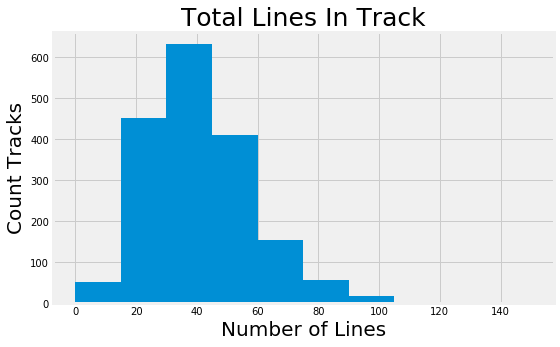

In [177]:
plt.figure(figsize=(8,5));
plt.title('Total Lines In Track', fontsize=25);
plt.xlabel('Number of Lines', fontsize=20);
plt.ylabel('Count Tracks', fontsize=20);
plt.hist(lyric_df['total_lines_track'], range=(0,150));

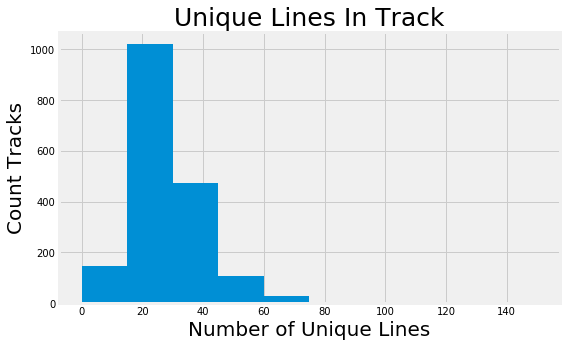

In [178]:
plt.figure(figsize=(8,5));
plt.title('Unique Lines In Track', fontsize=25);
plt.xlabel('Number of Unique Lines', fontsize=20);
plt.ylabel('Count Tracks', fontsize=20);
plt.hist(lyric_df['unique_lines_track'], range=(0,150));

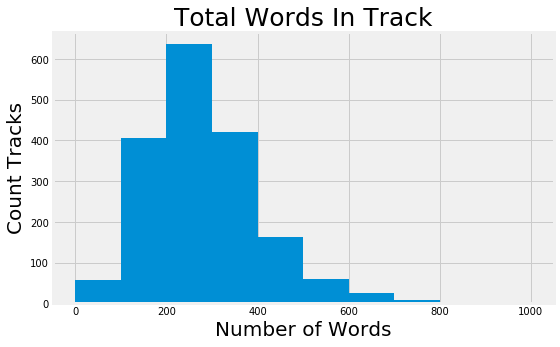

In [179]:
plt.figure(figsize=(8,5));
plt.title('Total Words In Track', fontsize=25);
plt.xlabel('Number of Words', fontsize=20);
plt.ylabel('Count Tracks', fontsize=20);
plt.hist(lyric_df['total_words_track'], range=(0, 1000));

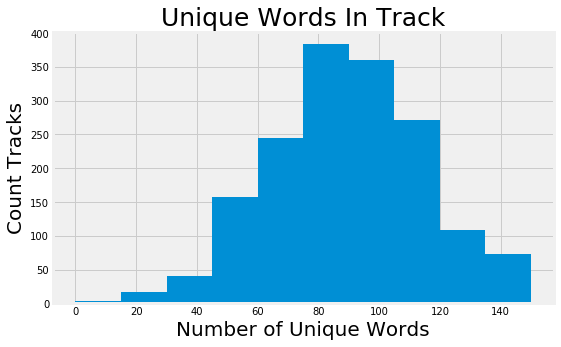

In [180]:
plt.figure(figsize=(8,5));
plt.title('Unique Words In Track', fontsize=25);
plt.xlabel('Number of Unique Words', fontsize=20);
plt.ylabel('Count Tracks', fontsize=20);
plt.hist(lyric_df['unique_words_track'], range=(0,150));

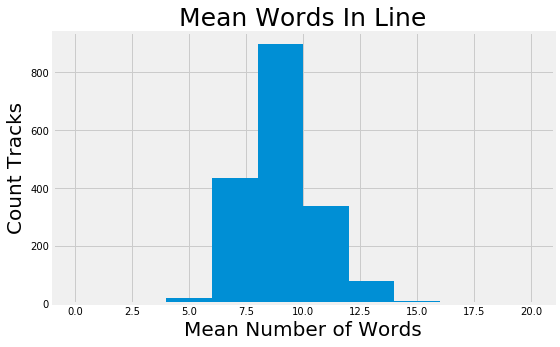

In [181]:
plt.figure(figsize=(8,5));
plt.title('Mean Words In Line', fontsize=25);
plt.xlabel('Mean Number of Words', fontsize=20);
plt.ylabel('Count Tracks', fontsize=20);
plt.hist(lyric_df['mean_words_line'], range=(0,20));

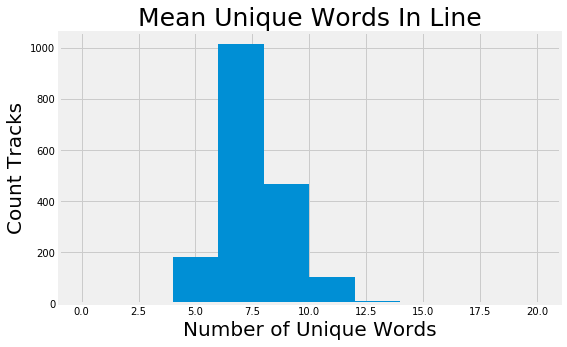

In [182]:
plt.figure(figsize=(8,5));
plt.title('Mean Unique Words In Line', fontsize=25);
plt.xlabel('Number of Unique Words', fontsize=20);
plt.ylabel('Count Tracks', fontsize=20);
plt.hist(lyric_df['mean_unique_words_line'], range=(0,20));

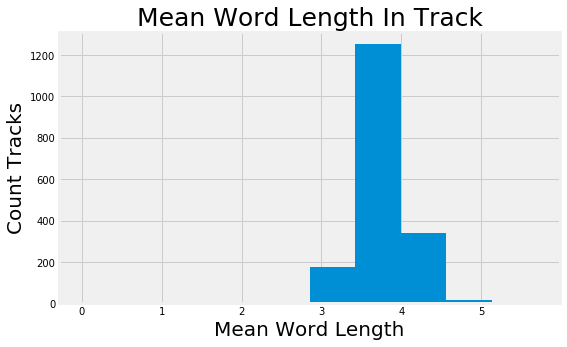

In [183]:
plt.figure(figsize=(8,5));
plt.title('Mean Word Length In Track', fontsize=25);
plt.xlabel('Mean Word Length', fontsize=20);
plt.ylabel('Count Tracks', fontsize=20);
plt.hist(len_words_track);

In [229]:
trace1 = go.Histogram(
    x=lyric_df['total_words_track'],
    opacity=0.75,
    hoverinfo=['x'],
    name='Total Words',
)
trace2 = go.Histogram(
    x=lyric_df['unique_words_track'],
    opacity=0.75,
    hoverinfo=['x'],
    name='Unique Words',
)

data = [trace1, trace2]
layout = go.Layout(barmode='overlay',
                   title='Total vs Unique Words in Track',
                   xaxis=dict(
                            title='Words in Track'
                            ),
                   yaxis=dict(
                            title='Count Tracks')
                  )

fig = go.Figure(data=data, layout=layout)

py.plot(fig, filename='words_overlay', auto_open=True)

'https://plot.ly/~csinatra/2'

In [228]:
trace1 = go.Histogram(
    x=lyric_df['total_lines_track'],
    opacity=0.75,
    hoverinfo=['x'],
    name='Total Lines',
)
trace2 = go.Histogram(
    x=lyric_df['unique_lines_track'],
    opacity=0.75,
    hoverinfo=['x'],
    name='Unique Lines',
)

data = [trace1, trace2]
layout = go.Layout(barmode='overlay',
                   title='Total vs Unique Lines in Track',
                   xaxis=dict(
                            title='Lines in Track'
                            ),
                  yaxis=dict(
                            title='Count Tracks')
                  )

fig = go.Figure(data=data, layout=layout)

py.plot(fig, filename='lines_overlay', auto_open=True)

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~csinatra/0 or inside your plot.ly account where it is named 'lines_overlay'


'https://plot.ly/~csinatra/0'

In [233]:
trace1 = go.Histogram(
    x=lyric_df['mean_words_line'],
    opacity=0.75,
    hoverinfo=['x'],
    name='Total Words',
)
trace2 = go.Histogram(
    x=lyric_df['mean_unique_words_line'],
    opacity=0.75,
    hoverinfo=['x'],
    name='Unique Words',
)

data = [trace1, trace2]
layout = go.Layout(barmode='overlay',
                   title='Total vs Unique Words in Line',
                   xaxis=dict(
                            title='Mean Words in Line'
                            ),
                   yaxis=dict(
                            title='Count Tracks')
                   
                  )

fig = go.Figure(data=data, layout=layout)

py.plot(fig, filename='mean_words_overlay', auto_open=True)

'https://plot.ly/~csinatra/4'

In [184]:
lyric_df.describe()

,total_words_track,unique_words_track,total_lines_track,unique_lines_track,mean_words_line,mean_unique_words_line
count,1782.000000,1782.000000,1782.000000,1782.000000,1782.000000,1782.000000
mean,282.481481,96.005612,40.778339,27.631874,9.064646,7.581650
std,125.522564,37.827128,17.909176,12.125132,2.039929,1.684362
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,194.250000,74.000000,28.000000,20.000000,7.900000,6.600000
50%,267.000000,91.500000,38.000000,25.000000,8.800000,7.400000
75%,345.750000,112.000000,51.000000,33.000000,9.900000,8.300000
max,1339.000000,433.000000,224.000000,189.000000,55.400000,39.800000


In [235]:
lyric_df[lyric_df.loc[:,'total_lines_track'] < 5]

,lyrics,clean_lyrics,total_words_track,unique_words_track,total_lines_track,unique_lines_track,mean_words_line,mean_unique_words_line
track_id,,,,,,,,
4usvynbYaFqgm4olpzEp9u,"\n\nYou have to take a little, give a little, ...",you have to take a little give a little and le...,26,19,1,1,26.0,19.0


In [190]:
lyric_df.loc['4usvynbYaFqgm4olpzEp9u'].lyrics

'\n\nYou have to take a little, give a little, and let your cold heart break a little. thats the story of thats the glory of love\n\n'

In [ ]:
ods graphics / width=500 height=500; /* for 9.4M5 you might need NXYBINSMAX=1000000 */
proc iml;
/* define a function that creates and visualizes the repetition matrix */
def lyrics_grid(DSName, Title);
   use (DSName); read all var _CHAR_ into Word;  close;
   N = nrow(Word);
   M = j(N,N,0);                       /* allocate N x N matrix */
   do i = 1 to N;
      M[,i] = element(Word, Word[i]);  /* construct i_th row */
   end;
   run heatmapdisc(M) title=Title
       colorramp={white black} displayoutlines=0 showlegend=0;
 
   /* compute the proportion of 1s in the upper triangular portion of the matrix */
   upperIdx = loc(col(M)>row(M));
   return ( M[upperIdx][:] );  /* proportion of words that are repeated */
finish;
 
score = VizLyrics("Lyrics", "Here We Go Round the Mulberry Bush");
print score;

In [ ]:
# formatted_name, now, file_description= filename_format_log(file_path = '../assets/lyric_df.csv')

# lyric_df.to_csv(formatted_name, index=False)

In [ ]:
eda_df = pd.DataFrame(columns=['id', 'line', 'line_num', 'tag'])

for idx, track in lyric_df[['lyrics']].iterrows():
    track = re.sub('(\[[^\]]+\]\\n\\n)', '', track[0]) #removes tags without lyrics
    track = re.sub('\[[^\[]+(:[^\]]+)\]', '', track) #removes all text after :
    track = re.sub('\[[^\[]+(–[^\]]+)|\[[^\[]+(-\s[^\]]+)\]', '', track) #removes all after –
    track = re.sub('\[[^\[]+(\(([^\]]+))\]', '', track) #removes all after ()
    track = re.sub('(^|)(\[Ad-Libs\])|(\[Keisha\])|(\[Shane Powers\])', '', track) #removes artist and non-standard tags
    track = re.sub('(^|)(\[Break\])|(\[Vocals / Lyrics By\])|(\[Skit\])', '', track) #removes artist and non-standard tags
    
    tags = re.findall('(\[[^\]]+\])', track) #finds all tags
    track = re.sub('(\[[^\]]+\])', '', track) #removes all tags
              
    track = track.strip().split('\n\n') 
    track_split = [verse.strip().split('\n') for verse in track] 
    
    v_count = len(track_split)

    for i in range(v_count):
        if len(tags) == v_count:
            tag = tags[i]
        else:
            tag = f'[verse {(i+1)}]'
        
        for j, line in enumerate(track_split[i]):
            index = 1
            
            row = {
            'id': idx,
            'line':line,
            'line_num':(j+1),
            'tag': tag.lower()
            }
            
            eda_df = eda_df.append(row, ignore_index=True)

In [ ]:
eda_df

In [ ]:
# formatted_name, now, file_description = filename_format_log(file_path ='../assets/eda_df.csv')
# eda_df.to_csv(formatted_name, index=False)

In [ ]:
# eda_df = pd.read_csv('../assets/1548892595_eda_df.csv')

In [ ]:
eda_df.tag.value_counts()[eda_df.tag.value_counts() < 10]

In [ ]:
drop = eda_df[eda_df['id'] == '4TYZXfu6VeblQMK2TwbDte'].index.tolist()

In [ ]:
eda_df = eda_df.drop(drop, axis=0)

In [ ]:
eda_df[eda_df.loc[:,'tag'] == '[verse 55]']

In [ ]:
lyric_df.loc['6xYd4zCVeSp80Un2Rl9wDs',:]['lyrics']

In [ ]:
off_verse = eda_df[eda_df.id =='6xYd4zCVeSp80Un2Rl9wDs'].index.tolist()

In [ ]:
eda_df.tag.loc[off_verse] = eda_df.tag.loc[off_verse].map(lambda x: '[verse 1]')

In [ ]:
eda_df.loc[off_verse,'line_num'] = list(range(1,63))

In [ ]:
eda_df.tag.value_counts()

In [ ]:
eda_df[eda_df.tag.str.contains('\n')]

In [ ]:
eda_df[eda_df.loc[:,'tag'] == '[verse 28]']

In [ ]:
leagues = eda_df[eda_df.id =='2za6PlkAQAMMu0VFsfBoHC'].index.tolist()

In [ ]:
eda_df = eda_df.drop(index=leagues, axis=0)

In [ ]:
eda_df.describe()

In [ ]:
eda_df[eda_df.id == '1ZzbD3g1K6LY2S1w5cdowm']

In [ ]:
eda_df[eda_df.id == '3yPMLvxeEor7rbDLDseJFt']

In [ ]:
tracks = eda_df[eda_df.id == '3yPMLvxeEor7rbDLDseJFt'].index.tolist()

In [ ]:
eda_df = eda_df.drop(index=tracks, axis=0)

In [ ]:
eda_df.describe()

In [ ]:
eda_df.tag.value_counts()

In [ ]:
bad_tag = eda_df.tag[eda_df.tag.str.contains('\n')].index.tolist()

In [ ]:
eda_df = eda_df.drop(index=bad_tag,axis=0)

In [ ]:
eda_df.tag.value_counts()